In [314]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from scipy.ndimage import gaussian_filter1d
from torch.utils.data import DataLoader
from bachelors_thesis.modeling.datasets.sigloc_dataset import SigLocDataset
from bachelors_thesis.modeling.sigloc import SigLoc12, SigLocNolan
from bachelors_thesis.utils import apply_preprocessors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact("nateml-maastricht-university/bachelors-thesis/07_sigloc-nolan_baseline_best:best")
artifact_path = artifact.download()

run = api.run("nateml-maastricht-university/bachelors-thesis/re5hn11u")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)
cfg.model.context_encoder.enabled = True

# Load the model
checkpoint = torch.load(artifact_path + "/07_sigloc-nolan_baseline_best.pth", map_location=torch.device('cuda'))

# Cast the model to the correct type
model = SigLocNolan(cfg.model)
model.to("cuda")
model.load_state_dict(checkpoint)
model.eval()

wandb:   1 of 1 files downloaded.  


SigLocNolan(
  (local_encoder): InceptionEncoder(
    (encoder): Sequential(
      (0): InceptionBlock(
        (branch1): Sequential(
          (0): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (branch2): Sequential(
          (0): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
        (branch3): Sequential(
          (0): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(8, 32, kernel_size=(5,), stride=(1,), paddi

In [135]:
for name, module in model.local_encoder.encoder.named_modules():
    if isinstance(module, nn.Conv1d) and name.startswith("0."):
        print(name, module)

0.branch1.0 Conv1d(1, 16, kernel_size=(1,), stride=(1,))
0.branch2.0 Conv1d(1, 8, kernel_size=(1,), stride=(1,))
0.branch2.3 Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
0.branch3.0 Conv1d(1, 8, kernel_size=(1,), stride=(1,))
0.branch3.3 Conv1d(8, 32, kernel_size=(5,), stride=(1,), padding=(2,))
0.branch4.0 Conv1d(1, 8, kernel_size=(1,), stride=(1,))
0.branch4.3 Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
0.branch5.1 Conv1d(1, 16, kernel_size=(1,), stride=(1,))


In [126]:
import ast

# Load the validation data
val_data = np.load('../../data/processed/ptbxl100all/val.npy')
meta = pd.read_csv('../../data/processed/ptbxl100all/meta_val.csv')

# Convert scp code strings to dictionaries
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(codes_above_threshold)

print(val_data.shape)
print(meta.shape)

(2183, 1000, 6)
(2183, 31)


In [127]:
# Preprocess the data
val_data_filtered = apply_preprocessors(val_data, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)

In [128]:
# Convert to torch tensors
val_data_tensor = torch.tensor(val_data_filtered, dtype=torch.float32).to("cuda")

In [129]:
# Permute to (batch_size, channels, seq_len)
val_data_tensor = val_data_tensor.permute(0, 2, 1)

In [130]:
val_data_tensor[0, 0].unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 1000])

In [187]:
# Register a forward hook to capture activations
activations = {}
hooks = []

def make_hook_fn(name):
    def hook_fn(module, input, output):
        activations[name] = output.detach()
    return hook_fn

num = 0
for name, module in model.local_encoder.encoder.named_modules():
    if isinstance(module, nn.Conv1d) and name.startswith("2."):
        hook_fn = make_hook_fn(f"{name}")
        hook = module.register_forward_hook(hook_fn)
        hooks.append(hook)
        print(f"Registered hook for {name}")
        num += 1

sample = 0
with torch.no_grad():
    x = val_data_tensor[sample].unsqueeze(0)
    _ = model(x)

# Unregister hooks
for hook in hooks:
    hook.remove()

Registered hook for 2.branch1.0
Registered hook for 2.branch2.0
Registered hook for 2.branch2.3
Registered hook for 2.branch3.0
Registered hook for 2.branch3.3
Registered hook for 2.branch4.0
Registered hook for 2.branch4.3
Registered hook for 2.branch5.1


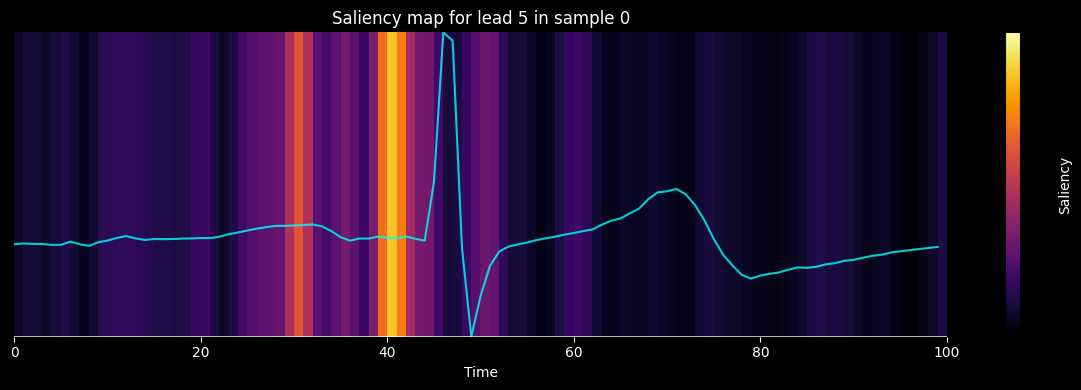

In [247]:
sample = 0

time_window = (0, 100)

x = val_data_tensor[sample].unsqueeze(0)
x.requires_grad = True

output = model(x)[1][0]
lead = 5
output = output[lead]

target_idx = output.argmax()
target = output[target_idx]

target.backward()

saliency = x.grad.data.abs()[0, lead].cpu().numpy()
saliency = saliency / saliency.max()
saliency = saliency[time_window[0]:time_window[1]]
saliency_smooth = gaussian_filter1d(saliency, sigma=1)
saliency_2d = saliency_smooth[np.newaxis, :]

ecg = x[0, lead].cpu().detach().numpy()
ecg = ecg[time_window[0]:time_window[1]]
ecg_scaled = (ecg - ecg.min()) / (ecg.max() - ecg.min())

fig, ax = plt.subplots(figsize=(12, 4))

ax.imshow(saliency_2d,
          cmap='inferno',
          aspect='auto',
          extent=[0, len(ecg), 0, 1],
          norm=plt.Normalize(vmin=0.01, vmax=saliency.max()))
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
cbar.set_label('Saliency', color='white')
ax.plot(np.arange(len(ecg)), ecg_scaled, color='cyan', linewidth=1.5, linestyle='-', label='ECG', alpha=0.8)
ax.set_title(f"Saliency map for lead {lead} in sample {sample}")
ax.set_yticks([])
ax.set_xlabel('Time')
# Set axis labels and ticks to white
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.set_facecolor('black')
ax.grid(False)
ax.axhline(y=0, color='white', linewidth=2, alpha=0.8)
for spine in ax.spines.values():
    spine.set_visible(False)
fig.patch.set_facecolor('black')
plt.tight_layout()
plt.show()

In [311]:
sample = 0
time_window = (0, 200)

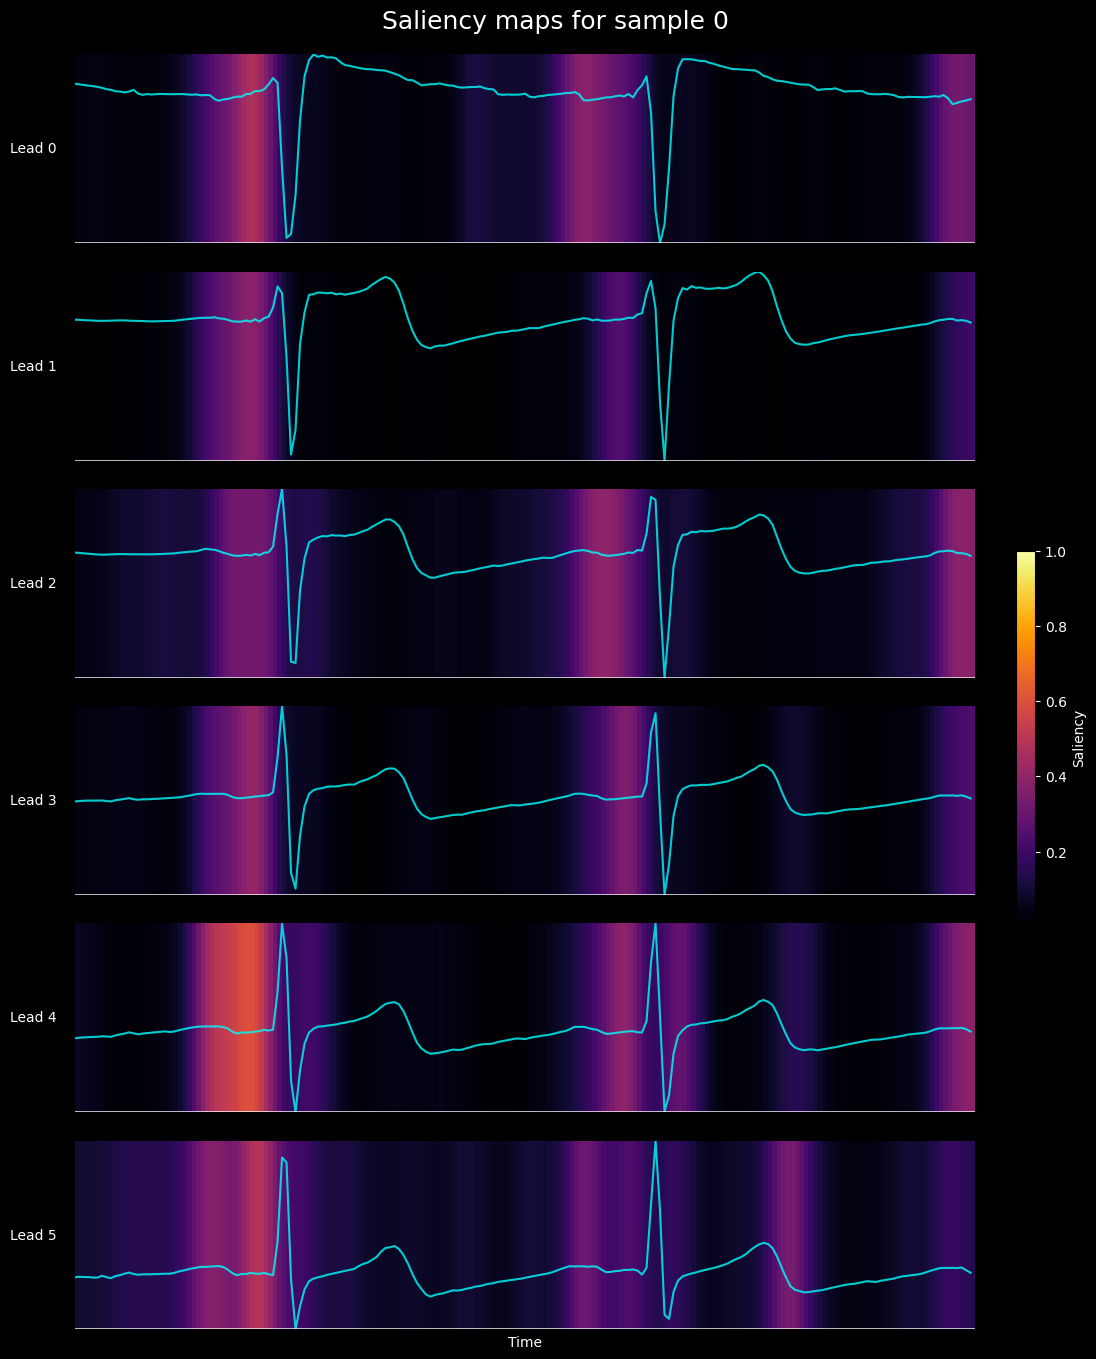

In [312]:
lead_indices = [0, 1, 2, 3, 4, 5]  # define the leads you want to visualize

x = val_data_tensor[sample].unsqueeze(0)  # shape [1, L, T]
x.requires_grad = True

# Get output and select the classification head output
output = model(x)[1][0]  # [num_leads, num_classes]

# Create subplots
num_leads = len(lead_indices)
fig, axes = plt.subplots(num_leads, 1, figsize=(12, 2.5 * num_leads), sharex=True,
                         gridspec_kw={'hspace': 0.15})

for i, lead in enumerate(lead_indices):
    lead_output = output[lead]
    target_idx = lead_output.argmax()
    target = lead_output[target_idx]

    model.zero_grad()
    x.grad = None
    target.backward(retain_graph=True)

    saliency = x.grad.data.abs()[0, lead].cpu().numpy()
    saliency = saliency / saliency.max()
    saliency = saliency[time_window[0]:time_window[1]]
    saliency_smooth = gaussian_filter1d(saliency, sigma=3)
    saliency_2d = saliency_smooth[np.newaxis, :]

    ecg = x[0, lead].cpu().detach().numpy()
    ecg = ecg[time_window[0]:time_window[1]]
    ecg_scaled = (ecg - ecg.min()) / (ecg.max() - ecg.min())

    ax = axes[i] if num_leads > 1 else axes
    im = ax.imshow(saliency_2d,
                   cmap='inferno',
                   aspect='auto',
                   extent=[0, len(ecg), 0, 1],
                   norm=plt.Normalize(vmin=0.01, vmax=saliency.max()))

    ax.plot(np.arange(len(ecg)), ecg_scaled, color='cyan', linewidth=1.5, linestyle='-', alpha=0.8)

    # Minimal labeling
    ax.set_yticks([])
    ax.set_ylabel(f"Lead {lead}", color='white', rotation=0, labelpad=30, fontsize=10, va='center')
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.axhline(y=0, color='white', linewidth=2, alpha=0.8)

    # Clean borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Hide x-ticks on all but last subplot
    if i < num_leads - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time', color='white')

# Add a single colorbar to the side
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Saliency', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

# Title for the whole figure
fig.suptitle(f'Saliency maps for sample {sample}', color='white', fontsize=18)
fig.patch.set_facecolor('black')

#plt.tight_layout(rect=[0, 0, 0.97, 0.90])
plt.subplots_adjust(left=0.1, right=0.85, top=0.95, bottom=0.1)
plt.show()

In [317]:
# Create a dataloader for the validation data
dataset = SigLocDataset(val_data_tensor)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
logits = np.zeros((len(dataset), 6, 6))
for idx, batch in enumerate(dataloader):
    # Move the batch to the GPU
    batch = batch.to('cuda')

    if idx == 0:
        print(batch.shape)
    
    # Make predictions
    with torch.no_grad():
        _, these_logits = model(batch)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()

logits.shape

torch.Size([64, 6, 1000])


(2183, 6, 6)

In [330]:
# Get indices of correct predictions
correct = np.all(np.argmax(logits, axis=2) == np.arange(6), axis=1).reshape(1, -1)
correct_indices = np.where(correct)[1]
wrong_indices = np.where(~correct)[1]
print(len(correct_indices), len(wrong_indices))

1914 269


In [ ]:
from tqdm import tqdm

saliency_per_lead_correct = {lead: [] for lead in lead_indices}
saliency_per_lead_wrong = {lead: [] for lead in lead_indices}

for sample_idx in tqdm(range(len(val_data_tensor))):
    x = val_data_tensor[sample_idx].unsqueeze(0)
    x.requires_grad = True

    # Get output and select the classification head output
    output = model(x)[1][0]  # [num_leads, num_classes]

    for lead in lead_indices:
        target_idx = output[lead].argmax()
        target = output[lead][target_idx]

        model.zero_grad()
        x.grad = None
        target.backward(retain_graph=True)

        # Get saliency
        saliency = x.grad.data.abs()[0, lead].cpu().numpy()
        saliency = saliency / saliency.max()

        if sample_idx in correct_indices:
            saliency_per_lead_correct[lead].append(saliency)
        else:
            saliency_per_lead_wrong[lead].append(saliency)

mean_saliency_per_lead_correct = {
    lead: np.mean(np.stack(saliencies), axis=0)
    for lead, saliencies in saliency_per_lead_correct.items()
}

mean_saliency_per_lead_wrong = {
    lead: np.mean(np.stack(saliencies), axis=0)
    for lead, saliencies in saliency_per_lead_wrong.items()
}

100%|██████████| 2183/2183 [03:11<00:00, 11.38it/s]


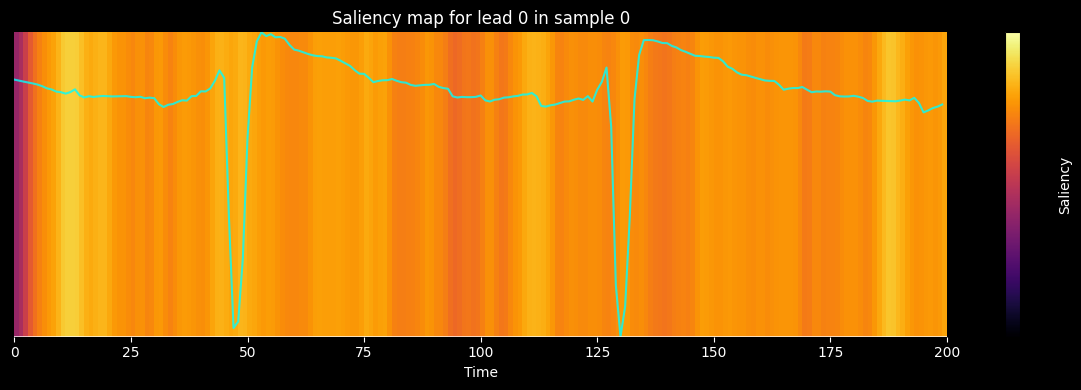

In [334]:
sample = 0
lead = 0

saliency_correct = mean_saliency_per_lead_correct[lead]
saliency_correct = saliency_correct / saliency_correct.max()
saliency_correct = saliency_correct[time_window[0]:time_window[1]]
saliency_correct_smooth = gaussian_filter1d(saliency_correct, sigma=1)
saliency_correct_2d = saliency_correct_smooth[np.newaxis, :]

saliency_wrong = mean_saliency_per_lead_wrong[lead]
saliency_wrong = saliency_wrong / saliency_wrong.max()
saliency_wrong = saliency_wrong[time_window[0]:time_window[1]]
saliency_wrong_smooth = gaussian_filter1d(saliency_wrong, sigma=1)
saliency_wrong_2d = saliency_wrong_smooth[np.newaxis, :]

ecg = val_data_tensor[sample, lead].cpu().detach().numpy()
ecg = ecg[time_window[0]:time_window[1]]
ecg_scaled = (ecg - ecg.min()) / (ecg.max() - ecg.min())

fig, ax = plt.subplots(figsize=(12, 4))

ax.imshow(saliency_wrong_2d,
          cmap='inferno',
          aspect='auto',
          extent=[0, len(ecg), 0, 1],
          norm=plt.Normalize(vmin=0.01, vmax=saliency.max()))
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
cbar.set_label('Saliency', color='white')
ax.plot(np.arange(len(ecg)), ecg_scaled, color='cyan', linewidth=1.5, linestyle='-', label='ECG', alpha=0.8)
ax.set_title(f"Saliency map for lead {lead} in sample {sample}")
ax.set_yticks([])
ax.set_xlabel('Time')
# Set axis labels and ticks to white
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.set_facecolor('black')
ax.grid(False)
ax.axhline(y=0, color='white', linewidth=2, alpha=0.8)
for spine in ax.spines.values():
    spine.set_visible(False)
fig.patch.set_facecolor('black')
plt.tight_layout()
plt.show()

In [180]:
x = val_data_tensor[sample].unsqueeze(0)
x.requires_grad = True
output = model(x)[1][0]
output = output  # Get the first element of the batch
target = 0  # or target class index

output[0, target].backward()
saliency = x.grad.abs().squeeze().cpu().numpy()

Error in callback <function _draw_all_if_interactive at 0x000001C357F2DAB0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

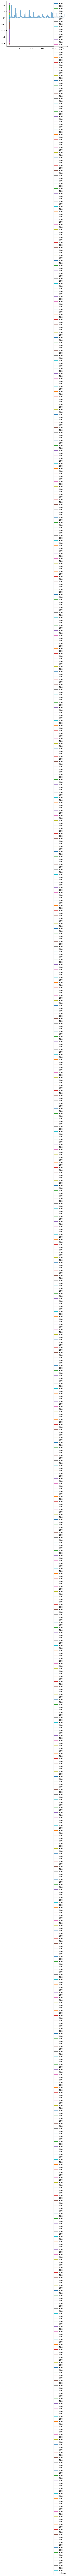

In [218]:
plt.plot(x.squeeze().cpu().detach(), label="ECG")
plt.plot(saliency / saliency.max(), label="Saliency", alpha=0.6)
plt.legend()

In [160]:
# Remove activations that are not needed
try:
    del activations['0.branch1.0']
    del activations['0.branch2.0']
    del activations['0.branch3.0']
    del activations['0.branch4.0']
except KeyError:
    pass

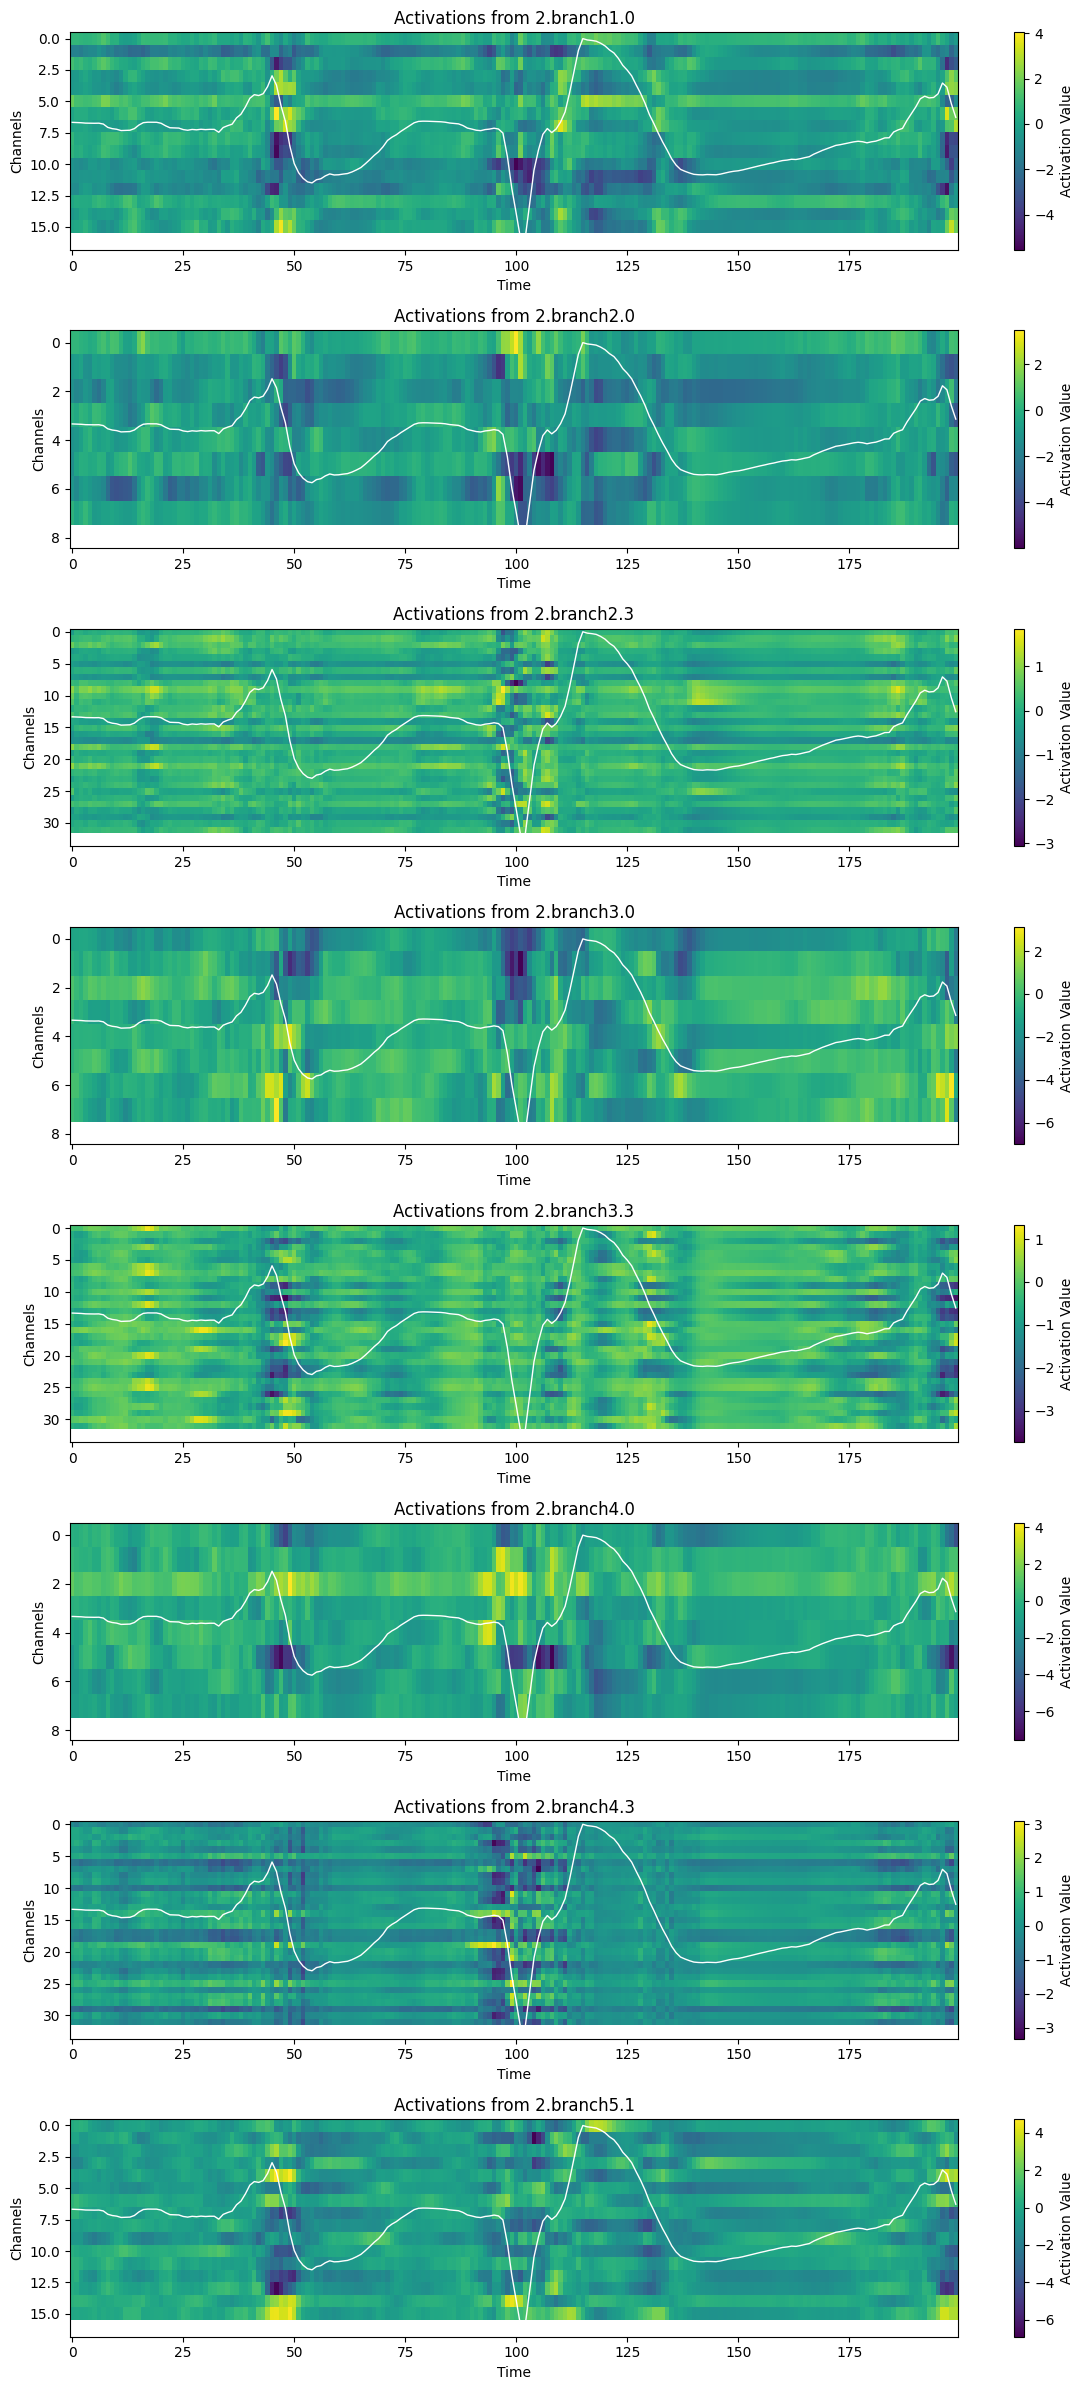

In [166]:
time_window = (400, 600)

lead = 0
ecg_segment = val_data_tensor[sample, lead].cpu().numpy()[time_window[0]:time_window[1]]  # shape: [time]

# Sort keys to keep layers in order (e.g., conv0, conv2, ...)
#sorted_keys = sorted(activations.keys(), key=lambda x: int(x.replace('branch_', '')))

num_layers = len(activations.keys())
plt.figure(figsize=(12, 3 * num_layers))

for i, key in enumerate(activations.keys()):
    act = activations[key].cpu().numpy()[0]  # shape: [channels, time]
    act = act[:, time_window[0]:time_window[1]]  # Apply time window
    n_channels, n_time = act.shape

    # Normalize ECG to activation value range
    ecg_norm = (ecg_segment - ecg_segment.min()) / (ecg_segment.max() - ecg_segment.min())
    ecg_scaled = ecg_norm * n_channels  # scale to match heatmap y-axis

    plt.subplot(num_layers, 1, i + 1)
    plt.imshow(act, aspect='auto', cmap='viridis')
    plt.plot(np.arange(n_time), ecg_scaled, color='white', linewidth=1.0, label="ECG")
    plt.colorbar(label='Activation Value')
    plt.title(f'Activations from {key}')
    plt.xlabel('Time')
    plt.ylabel('Channels')

plt.tight_layout()
plt.show()
